# Poisson Race Model Tutorial

This short tutorial shows how to (1) simulate synthetic reaction times with the Poisson race simulator from `ssms-simulators`, (2) fit the analytical Poisson race likelihood provided by HSSM, and (3) inspect the recovered parameters with ArviZ.


In [1]:
import arviz as az
import numpy as np
import pandas as pd
import pymc as pm

import hssm

hssm.set_floatX("float32")
az.style.use("arviz-whitegrid")

rng = np.random.default_rng(123)


Setting PyTensor floatX type to float32.
Setting "jax_enable_x64" to False. If this is not intended, please set `jax` to False.


## Simulate with ssms-simulators

`hssm.simulate_data` wraps the `ssms-simulators` Poisson race generator. The simulator names its accumulator-specific parameters with zero-based indices (`r0`/`r1` and `k0`/`k1`). We mirror those values into an HSSM-friendly dict so posterior checks line up with the likelihood parameterization (`r1`, `r2`, `k1`, `k2`, `t`).


In [2]:
ssms_params = {
    "r0": 2.8,
    "r1": 3.4,
    "k0": 1.6,
    "k1": 1.2,
    "t": 0.25,
}
true_params = {
    "r1": ssms_params["r1"],
    "r2": ssms_params["r0"],
    "k1": ssms_params["k1"],
    "k2": ssms_params["k0"],
    "t": ssms_params["t"],
}
n_trials = 400

data = hssm.simulate_data(
    model="poisson_race",
    theta=ssms_params,
    size=n_trials,
    random_state=123,
)
data.head()


,rt,response
0,0.410400,1.0
1,0.367651,-1.0
2,0.532004,-1.0
3,0.888673,-1.0
4,0.428676,-1.0


## Fit the Poisson race likelihood

We pass the simulated data into an `HSSM` object that uses the analytical Poisson race likelihood. The defaults already enforce positivity for all parameters; you can override them by passing a `prior_settings` dict.


In [3]:
poisson_model = hssm.HSSM(
    data=data,
    model="poisson_race",
    loglik_kind="analytical",
    prior_settings=None,
)

idata = poisson_model.sample(
    draws=1000,
    tune=1000,
    chains=2,
    cores=2,
    target_accept=0.9,
    random_seed=123,
)


Model initialized successfully.
Using default initvals. 



Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [k1, t, k2, r2, r1]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 109 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
/Users/hayden/miniconda3/envs/hssm-dev/lib/python3.12/site-packages/numpy/_core/numeric.py:1211: RuntimeWarning: divide by zero encountered in dot
  res = dot(at, bt)
/Users/hayden/miniconda3/envs/hssm-dev/lib/python3.12/site-packages/numpy/_core/numeric.py:1211: RuntimeWarning: overflow encountered in dot
  res = dot(at, bt)
/Users/hayden/miniconda3/envs/hssm-dev/lib/python3.12/site-packages/numpy/_core/numeric.py:1211: RuntimeWarning: invalid value encountered in dot
  res = dot(at, bt)
100%|██████████| 2000/2000 [00:00<00:00, 21827.37it/s]


## Compare posteriors against the ground truth

ArviZ summarises the marginal distributions and allows us to verify that the posterior means/credible intervals overlap the parameters used to simulate the data.


In [4]:
var_names = list(true_params.keys())
summary = az.summary(idata, var_names=var_names)
summary["true_value"] = [true_params[name] for name in summary.index]
summary


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,true_value
r1,3.776,0.455,2.920,4.609,0.021,0.013,444.0,635.0,1.01,3.40
r2,3.247,0.470,2.437,4.190,0.021,0.013,494.0,545.0,1.01,2.80
k1,1.299,0.114,1.097,1.513,0.006,0.003,410.0,630.0,1.01,1.20
k2,1.731,0.167,1.436,2.061,0.008,0.005,486.0,719.0,1.01,1.60
t,0.251,0.003,0.247,0.254,0.000,0.000,414.0,607.0,1.00,0.25


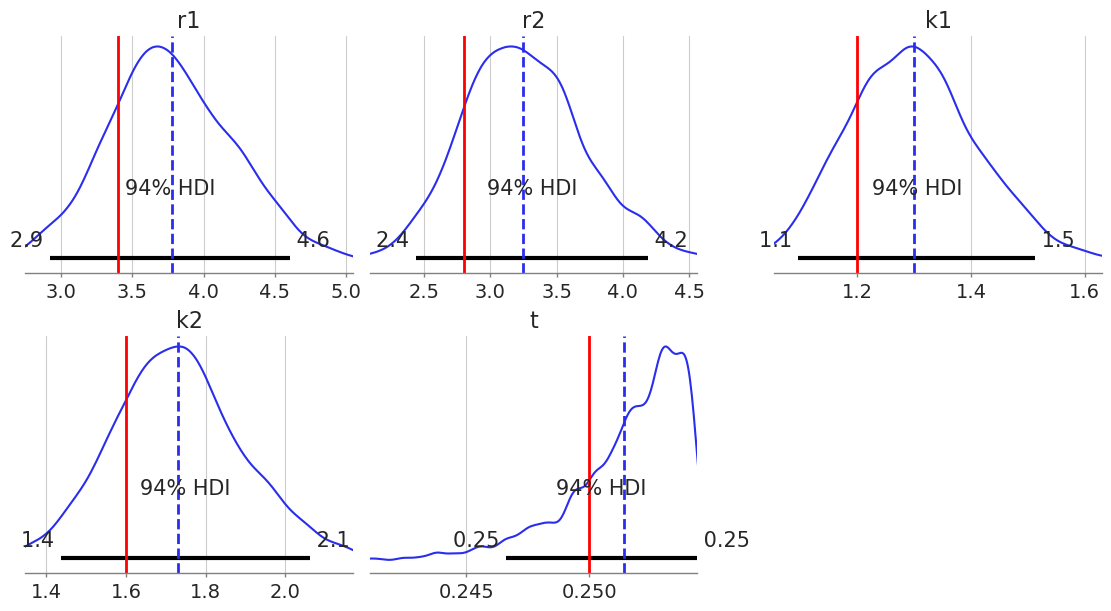

In [5]:
axes = az.plot_posterior(
    idata,
    var_names=var_names,
    figsize=(11, 6),
    hdi_prob=None,
    point_estimate=None,
);

for i, (ax, var) in enumerate(zip(np.ravel(np.atleast_1d(axes)), var_names)):
    post_vals = idata.posterior[var].values.ravel()

    lo, hi = np.quantile(post_vals, [0.005, 0.995])
    post_mean = np.mean(post_vals)

    ax.axvline(post_mean, color='C0', linestyle='--', linewidth=2, label='posterior mean')
    ax.axvline(true_params[var], color='red', linestyle='-', linewidth=2, label='true value')
    ax.set_xlim(lo, hi)

